In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from pathlib import Path
from src.preprocessing import PreprocessDataTrainTestSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import  StandardScaler
from typing import Optional

from src.init_parameters import init_parameters
from src.vectorize import vectorize_data
from src.gibbs_sampler import gibbs_sampler_joint_post

In [3]:
########
# Plot #
########

def plot_signal(vec, title = "signal"):
    fig = px.line(vec, template = "plotly_dark", title = title)
    fig.show()

def plot_sample(
    sampling: np.ndarray,
    size: Optional[int] = 10,
    levels: Optional[int] = 20,
    title: Optional[str] = "sampling"
) -> None:
    """
    Plot a scatter plot and kernel density estimate of a 2D sampling.

    Args:
    - sampling (np.ndarray): 2D array representing the sampled data.
    - size (Optional[int]): Size of the figure (default is 10).
    - levels (Optional[int]): Number of levels in the contour plot (default is 20).
    - title (Optional[str]): Title of the plot (default is "sampling").

    Returns:
    None
    """
    fig_sampling = plt.figure(figsize=(size, size))
    plt.scatter(x = sampling[:,0], y = sampling[:,1], marker ="o", alpha = 0.1)
    sns.kdeplot(x = sampling[:,0], y = sampling[:,1], alpha = 1, levels = levels, cmap= "Blues" )
    plt.title(title)
    fig_sampling.show()

def plot_mcmc_traj(
    traj: np.ndarray,
    size: Optional[int] = 10,
    trajname: Optional[str] = "HM"
) -> None:
    """
    Plot the trajectory of an MCMC sampler.

    Args:
    - traj (np.ndarray): 2D array representing the MCMC trajectory.
    - size (Optional[int]): Size of the figure (default is 10).
    - trajname (Optional[str]): Name of the MCMC sampler (default is "HM").

    Returns:
    None
    """
    traj_length = traj.shape[0]
    dim = traj.shape[1]
    colors = sns.color_palette("viridis", traj_length).as_hex()
    plt.figure(figsize=(size, size))
    sns.set(style='dark')

    if dim==2 or dim > 5:
        plt.scatter(x = traj[:,0], y = traj[:,1], marker ="o", alpha = 0.5, color=colors)
    else:
        df = pd.DataFrame(traj, columns = np.arange(dim))
        df["step"] = np.arange(traj_length)
        sns.pairplot(df, hue="step", palette = colors)

    plt.title(f"Trajectory of the {trajname} sampler")
    plt.show()

def plot_autocorrelations(
    traj: np.ndarray,
    size: Optional[int] = 10,
    trajname: Optional[str] = "HM",
    nlags: Optional[int] = 80
) -> None:
    """
    Plot autocorrelations of an MCMC trajectory.

    Args:
    - traj (np.ndarray): 2D array representing the MCMC trajectory.
    - size (Optional[int]): Size of the figure (default is 10).
    - trajname (Optional[str]): Name of the MCMC sampler (default is "HM").
    - nlags (Optional[int]): Number of lags to plot (default is 80).

    Returns:
    None
    """
    dim = traj.shape[1]
    plt.figure(figsize=(size,size))
    for i in range(dim):
        pd.plotting.autocorrelation_plot(traj[:,i], label=f'Autocorrelation of dim {i}',linewidth=2)
    plt.title(f"Autocorrelations {trajname}")
    plt.xlim((0,nlags)) #limit lags
    plt.show()


def plot_hist(sample, title, nbins = 400):
    fig = px.histogram(sample,
                   histnorm='probability density',
                   title = title,
                   nbins = nbins
                  )
    fig.show()

In [4]:
SEED = 0
root_path = Path(os.getcwd())
data_path = root_path.joinpath("Macro1.csv")

# Simple validation

In [5]:
preprocess_train_test = PreprocessDataTrainTestSplit(data_path=data_path, split_date='1999-12-01', columns_to_del=['IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS'], normalize=True, max_date='2006-12-31')
train_df, test_df = preprocess_train_test.process()

X = train_df.drop('INDPRO', axis=1).values
y = train_df['INDPRO'].values

X_test = test_df.drop('INDPRO', axis=1).values
y_test = test_df['INDPRO'].values

In [9]:
np.random.seed(SEED)
T = X.shape[0]
k = X.shape[1]
l = 0
a = 1
b = 1
A = 1
B = 1
N_ITER_MH_SIGMA2 = 100000
BURN_IN_PERIOD_MH_SIGMA2 = 40000
JUMP_SIZE_MH_SIGMA2 = 1
N_ITER_GIBBS = 5000
BURN_IN_PERIOD = 1000

dct = init_parameters(T, k, l, a, b, A, B, X, N_ITER_MH_SIGMA2, BURN_IN_PERIOD_MH_SIGMA2, JUMP_SIZE_MH_SIGMA2)
data0 = vectorize_data(dct=dct,T=T,k=k,l=l,a=a,b=b,A=A,B=B)
data1, accu = gibbs_sampler_joint_post(data0, n_iter = N_ITER_GIBBS, burn_in_period=BURN_IN_PERIOD, n_iter_zi=1, debug = True)

In [11]:
print("Prior sigma2 sampled: {}".format(round(dct["sigma2"],2)))

Prior sigma2 sampled: 0.03


In [12]:
array_beta_pred = accu["beta post"]
beta_pred =0
for item in array_beta_pred:
    beta_pred+=item
beta_pred = beta_pred/(N_ITER_GIBBS-BURN_IN_PERIOD)
beta_pred = beta_pred[0]

In [13]:
beta_pred

array([ 1.00003958e+00,  9.96857120e-01,  7.08641932e-07, -2.32011624e-07,
        0.00000000e+00,  1.00481088e+00,  1.00023106e+00,  1.28133386e-05,
       -1.88581163e-06, -1.48284796e-06,  9.99215454e-01,  0.00000000e+00,
       -4.02701507e-07,  0.00000000e+00,  1.00075618e+00,  0.00000000e+00,
        8.03538712e-01,  5.33922751e-01,  1.00378489e+00,  0.00000000e+00,
        5.69636675e-06,  7.01974034e-06,  1.00094314e+00,  5.17811303e-01,
       -1.94369818e-07,  9.97665190e-01, -2.79288174e-06,  0.00000000e+00,
        4.45774190e-07,  0.00000000e+00,  7.96679353e-07,  0.00000000e+00,
        1.00025151e+00,  3.51870522e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.92916902e-06,  9.97941544e-01,  3.06362532e-07,
        1.00292308e+00,  9.99773112e-01,  9.98679193e-01,  1.00079082e+00,
        0.00000000e+00, -5.31752892e-07,  9.99125712e-01,  1.00036312e+00,
       -6.80380960e-07,  0.00000000e+00,  1.00108343e+00, -1.56563729e-06,
        9.99830250e-01,  

In [14]:
y_pred_train = X@beta_pred
y_pred_test = X_test @beta_pred

In [15]:
r2_train = r2_score(y, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Train R2: {}".format(r2_train))
print("Train MSE: {}".format(mse_train))
print("Test R2: {}".format(r2_test))
print("Test MSE: {}".format(mse_test))

Train R2: -1108.0185371746045
Train MSE: 152.0615147394724
Test R2: -2783.2089487429903
Test MSE: 646.5814923042032


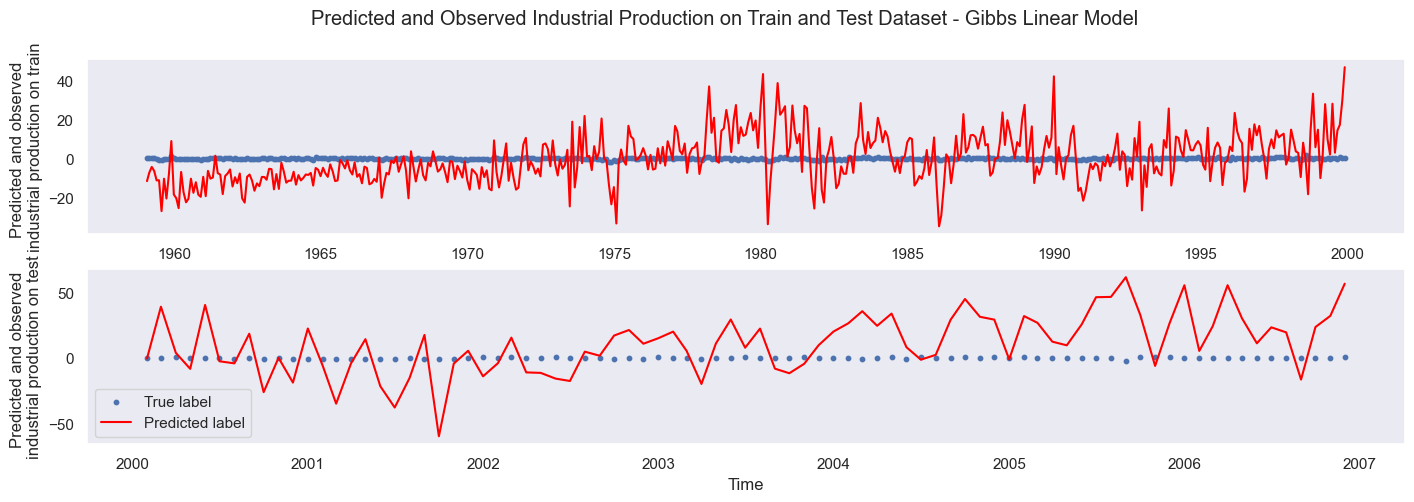

In [29]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(train_df.index, y, marker='o', s=10, label="True label")
plt.plot(train_df.index, y_pred_train, color='red', label="Predicted label")
plt.ylabel("Predicted and observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(test_df.index, y_test, marker='o', s=10, label="True label")
plt.plot(test_df.index, y_pred_test, color='red', label="Predicted label")
plt.xlabel('Time')
plt.ylabel("Predicted and observed \nindustrial production on test")

plt.suptitle("Predicted and Observed Industrial Production on Train and Test Dataset - Gibbs Linear Model")
plt.legend()
plt.show()

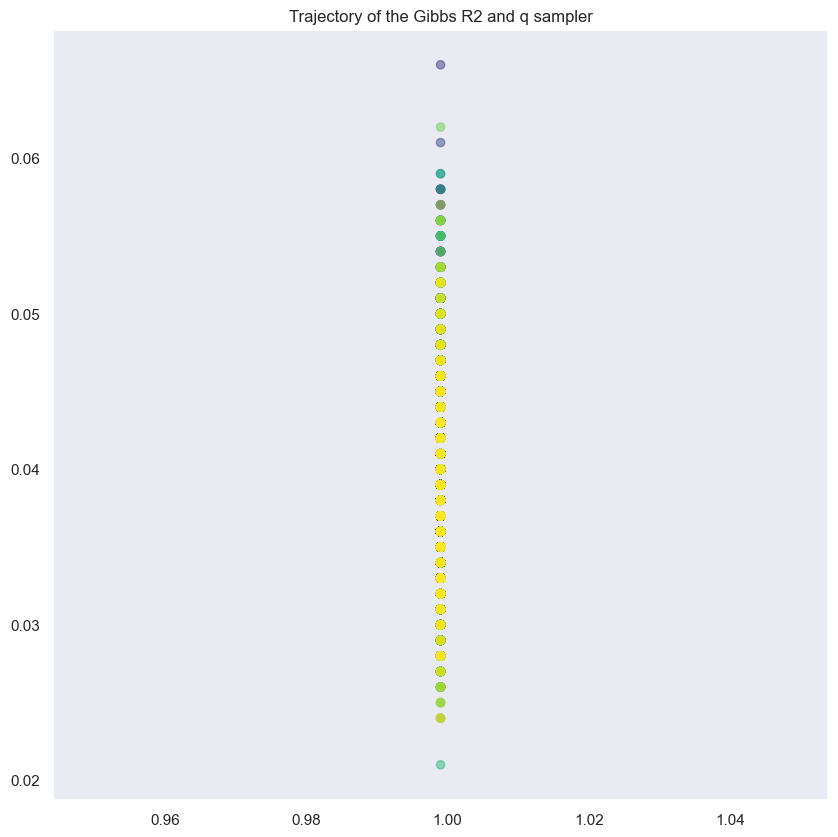

In [26]:
plot_mcmc_traj(pd.DataFrame({"R2 post": accu["R2 post"],"q post": accu["q post"]}).values, trajname = "Gibbs R2 and q")

# Cross validation

In [31]:
preprocess_train_test = PreprocessDataTrainTestSplit(data_path=data_path, split_date='1999-12-01', columns_to_del=['IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS'], normalize=False, max_date='2006-12-31')
train_df, test_df = preprocess_train_test.process()

X = train_df.drop('INDPRO', axis=1).values
y = train_df['INDPRO'].values

X_test = test_df.drop('INDPRO', axis=1).values
y_test = test_df['INDPRO'].values

In [37]:
X_train_transform.shape[0]

86

In [36]:
tscv = TimeSeriesSplit(n_splits=5)
list_mse_train = []
list_r2_train = []
list_mse_val = []
list_r2_val = []
list_beta_pred = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    scaler = StandardScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_val_transform = scaler.transform(X_val)
    k = X_train_transform.shape[1]
    T = X_train_transform.shape[0]
    dct = init_parameters(T, k, l, a, b, A, B, X_train_transform, N_ITER_MH_SIGMA2, BURN_IN_PERIOD_MH_SIGMA2, JUMP_SIZE_MH_SIGMA2)
    data0 = vectorize_data(dct=dct,T=T,k=k,l=l,a=a,b=b,A=A,B=B)
    data1, accu = gibbs_sampler_joint_post(data0, n_iter = N_ITER_GIBBS, burn_in_period=BURN_IN_PERIOD, n_iter_zi=1, debug = True)
    array_beta_pred = accu["beta post"]
    beta_pred =0
    for item in array_beta_pred:
        beta_pred+=item
    beta_pred = beta_pred/(N_ITER_GIBBS-BURN_IN_PERIOD)
    beta_pred = beta_pred[0]
    list_beta_pred.append(beta_pred)
    y_pred_train = X_train_transform @ beta_pred
    y_pred_val = X_val_transform @ beta_pred
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    list_mse_train.append(mse_train)
    list_r2_train.append(r2_train)
    list_mse_val.append(mse_val)
    list_r2_val.append(r2_val)

    print("Train R2: {}".format(r2_train))
    print("Train MSE: {}".format(mse_train))
    print("Val R2: {}".format(r2_val))
    print("Val MSE: {}".format(mse_val))

    plt.figure(figsize=(17,5))
    plt.subplot(2, 1, 1)
    plt.scatter(train_df.index[train_index], y_train, marker='o', s=10, label="True label")
    plt.plot(train_df.index[train_index], y_pred_train, color='red', label="Predicted label")
    plt.ylabel("Predicted and observed \nindustrial production on train")

    plt.subplot(2, 1, 2)
    plt.scatter(train_df.index[val_index], y_val, marker='o', s=10, label="True label")
    plt.plot(train_df.index[val_index], y_pred_val, color='red', label="Predicted label")
    plt.xlabel('Time')
    plt.ylabel("Predicted and observed \nindustrial production on validation")
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Predicted and Observed Industrial Production on Train and Validation Dataset - Frequentist Linear Regression")
    plt.legend()
    plt.show()

print("Average MSE - train: {}".format(sum(list_mse_train)/len(list_mse_train)))
print("Average R2 - train: {}".format(sum(list_r2_train)/len(list_r2_train)))
print("Average MSE - validation: {}".format(sum(list_mse_val)/len(list_mse_val)))
print("Average R2 - validation: {}".format(sum(list_r2_val)/len(list_r2_val)))

ValueError: could not broadcast input array from shape (109,) into shape (86,)